In [1]:
import sys
sys.path.append('..')

from utils.common import read_beacon_coords, read_beacon_data, process_beacon_data_for_strongthree, process_beacon_data_for_pos
import argparse
import pandas as pd



In [2]:
args = argparse.Namespace(beacon_coords_file='../data0830p2/beacon_coords.txt', beacon_data_dir='../data0830p2/', beacon_data_file = '../data0830p2/bluetoothData(91).txt', update_frequency=10)

actual_coords = read_beacon_coords(args.beacon_coords_file)
beacon_data = read_beacon_data(args.beacon_data_file)
print("beacon data",beacon_data)
print("beacon group num", len(beacon_data))

# positions = process_beacon_data_for_pos(args)

# print(args.beacon_data_file)

# print(positions)

beacon data [[{'uuid': '88400000-0000-0000-0000-000000000000', 'rssi': -63, 'accuracy': 14.323008481499683, 'time': 1724998425975}], [{'uuid': '88400000-0000-0000-0000-000000000000', 'rssi': -63, 'accuracy': 14.323008481499683, 'time': 1724998426075}], [{'uuid': '88400000-0000-0000-0000-000000000000', 'rssi': -62, 'accuracy': 12.296376053275772, 'time': 1724998426174}], [{'uuid': '88400000-0000-0000-0000-000000000000', 'rssi': -62, 'accuracy': 12.296376053275772, 'time': 1724998426277}], [{'uuid': '88400000-0000-0000-0000-000000000000', 'rssi': -62, 'accuracy': 12.296376053275772, 'time': 1724998426378}], [{'uuid': '88400000-0000-0000-0000-000000000000', 'rssi': -70, 'accuracy': 39.833273094050156, 'time': 1724998426478}], [{'uuid': '88400000-0000-0000-0000-000000000000', 'rssi': -62, 'accuracy': 12.296376053275772, 'time': 1724998426577}], [{'uuid': '88400000-0000-0000-0000-000000000000', 'rssi': -62, 'accuracy': 12.296376053275772, 'time': 1724998426680}], [{'uuid': '88400000-0000-00

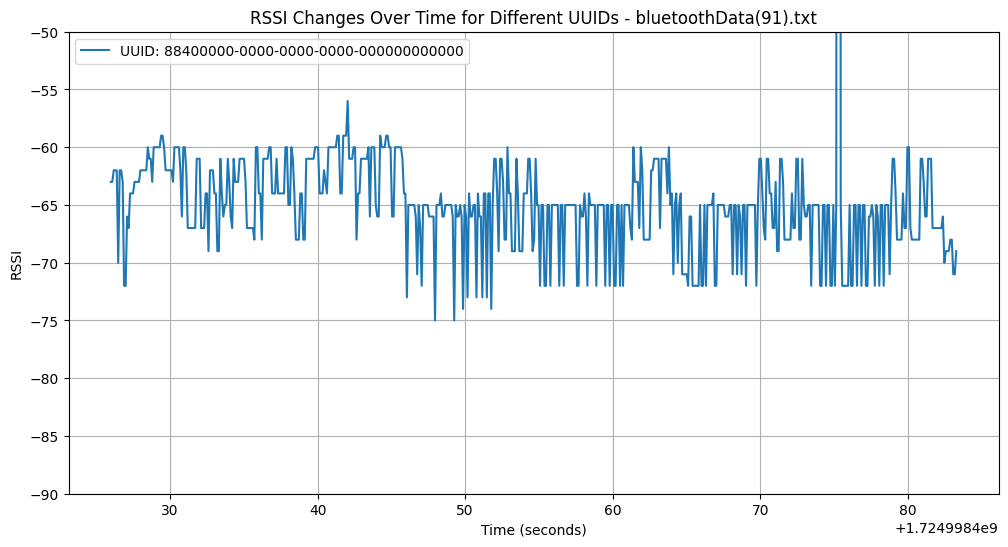

File: bluetoothData(91).txt
UUID: 88400000-0000-0000-0000-000000000000
  Number of data points: 572
  Min RSSI: -75
  Max RSSI: 127
  Average RSSI: -64.45





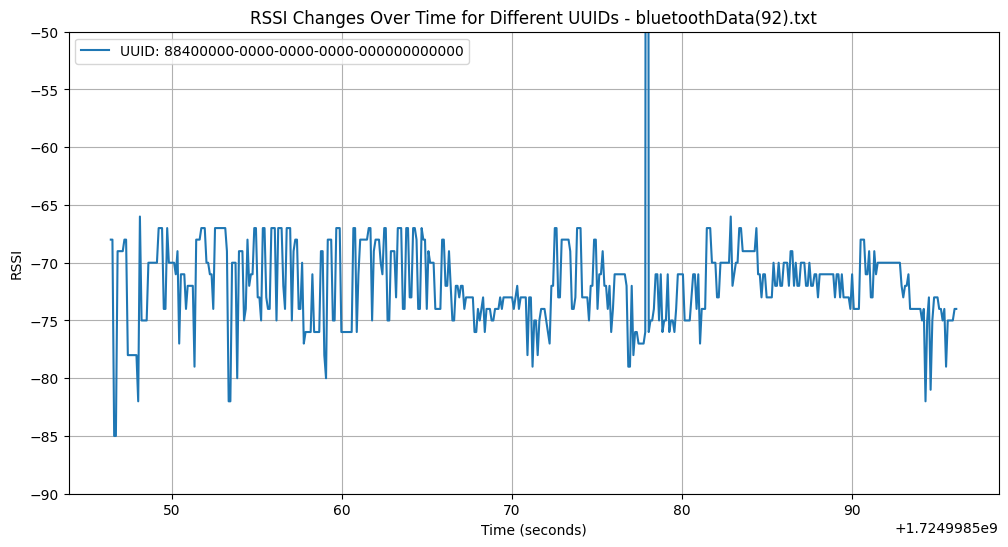

File: bluetoothData(92).txt
UUID: 88400000-0000-0000-0000-000000000000
  Number of data points: 496
  Min RSSI: -85
  Max RSSI: 127
  Average RSSI: -71.51





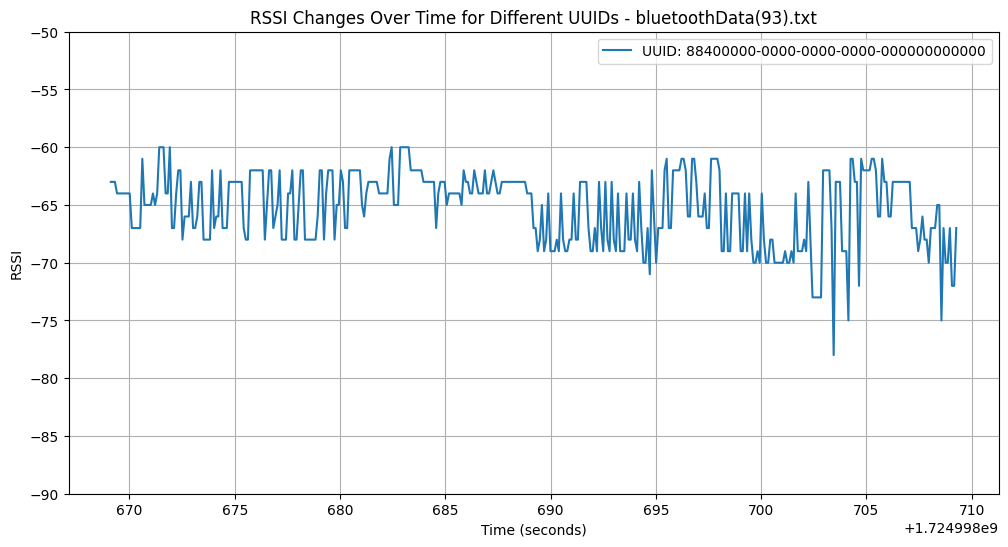

File: bluetoothData(93).txt
UUID: 88400000-0000-0000-0000-000000000000
  Number of data points: 401
  Min RSSI: -78
  Max RSSI: -60
  Average RSSI: -65.22





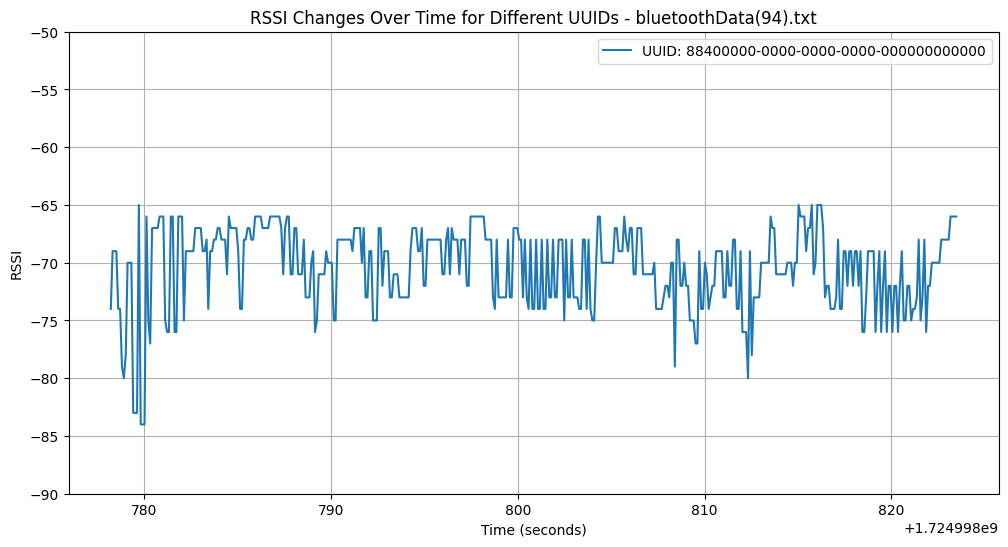

File: bluetoothData(94).txt
UUID: 88400000-0000-0000-0000-000000000000
  Number of data points: 452
  Min RSSI: -84
  Max RSSI: -65
  Average RSSI: -70.40





In [3]:
import os
import glob
import matplotlib.pyplot as plt
import numpy as np

data_files = sorted(glob.glob('../data0830p2/bluetoothData*.txt'))

for file_path in data_files:
    # Read beacon data from the current file
    beacon_data = read_beacon_data(file_path)
    
    # Create a dictionary to store RSSI values for each UUID
    uuid_rssi_data = {}

    # Collect RSSI data for each UUID
    for data_list in beacon_data:
        for beacon in data_list:
            uuid = beacon['uuid']
            rssi = beacon['rssi']
            time = beacon['time'] / 1000  # Convert milliseconds to seconds
            
            if uuid not in uuid_rssi_data:
                uuid_rssi_data[uuid] = {'time': [], 'rssi': []}
            
            uuid_rssi_data[uuid]['time'].append(time)
            uuid_rssi_data[uuid]['rssi'].append(rssi)

    # Plot RSSI changes for each UUID
    plt.figure(figsize=(12, 6))

    # Sort UUIDs to ensure consistent order
    sorted_uuids = sorted(uuid_rssi_data.keys())

    for uuid in sorted_uuids:
        data = uuid_rssi_data[uuid]
        plt.plot(data['time'], data['rssi'], label=f'UUID: {uuid}')

    plt.title(f'RSSI Changes Over Time for Different UUIDs - {os.path.basename(file_path)}')
    plt.xlabel('Time (seconds)')
    plt.ylabel('RSSI')
    plt.ylim(-90, -50)
    plt.legend()
    plt.grid(True)
    plt.show()

    # Print summary statistics
    print(f"File: {os.path.basename(file_path)}")
    for uuid in sorted_uuids:
        data = uuid_rssi_data[uuid]
        print(f"UUID: {uuid}")
        print(f"  Number of data points: {len(data['rssi'])}")
        print(f"  Min RSSI: {min(data['rssi'])}")
        print(f"  Max RSSI: {max(data['rssi'])}")
        print(f"  Average RSSI: {sum(data['rssi']) / len(data['rssi']):.2f}")
        print()
    print("\n" + "="*50 + "\n")

In [4]:
import numpy as np
from scipy.signal import medfilt
from filterpy.kalman import KalmanFilter
import re


# Dictionary to store filename to Kalman mean RSSI mapping
def apply_average_filter(data, window_size=5):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

def apply_median_filter(data, window_size=9):
    return medfilt(data, kernel_size=window_size)

def apply_kalman_filter(data):
    kf = KalmanFilter(dim_x=1, dim_z=1)
    kf.x = np.array([data[0]])
    kf.P *= 1000.
    kf.R = 5
    kf.Q = 0.1
    kf.H = np.array([[1.]])
    kf.F = np.array([[1.]])
    
    filtered_data = []
    for measurement in data:
        kf.predict()
        kf.update(measurement)
        filtered_data.append(kf.x[0])
    return filtered_data


# Dictionary to store filename to Kalman mean RSSI mapping
filename_to_median_mean_rssi = {}
# from collections import defaultdict
# filename_to_rssi = defaultdict(lambda: {"kalman": 0, "median": 0, "avg": 0})

# Apply filters and calculate mean signal strength for each UUID
for file_path in data_files:
    beacon_data = read_beacon_data(file_path)
    
    # Create a dictionary to store RSSI values for each UUID
    uuid_rssi_data = {}

    # Collect RSSI data for each UUID
    for data_list in beacon_data:
        for beacon in data_list:
            uuid = beacon['uuid']
            rssi = beacon['rssi']
            time = beacon['time'] / 1000  # Convert milliseconds to seconds
            
            if uuid not in uuid_rssi_data:
                uuid_rssi_data[uuid] = {'time': [], 'rssi': []}
            
            uuid_rssi_data[uuid]['time'].append(time)
            uuid_rssi_data[uuid]['rssi'].append(rssi)

    # Plot original and filtered RSSI changes for each UUID
    # plt.figure(figsize=(15, 10))

    # Sort UUIDs to ensure consistent order
    sorted_uuids = sorted(uuid_rssi_data.keys())

    kalman_mean_rssi_list = []

    # for i, uuid in enumerate(sorted_uuids):
    #     data = uuid_rssi_data[uuid]
    #     time = np.array(data['time'])
    #     rssi = np.array(data['rssi'])
        
    #     avg_filtered = apply_average_filter(rssi)
    #     median_filtered = apply_median_filter(rssi)
    #     kalman_filtered = apply_kalman_filter(rssi)
        
    #     plt.subplot(len(sorted_uuids), 1, i+1)
    #     plt.plot(time, rssi, label='Original', alpha=0.5)
    #     plt.plot(time[2:-2], avg_filtered, label='Average Filter')
    #     plt.plot(time[2:-2], median_filtered[2:-2], label='Median Filter')
    #     plt.plot(time, kalman_filtered, label='Kalman Filter')
        
    #     plt.xlabel('Time (seconds)')
    #     plt.ylabel('RSSI')
    #     plt.legend()
    #     plt.grid(True)
    #     plt.title(f'UUID: {uuid}')  # Add UUID to the subplot title

    #     kalman_mean_rssi_list.append(np.mean(kalman_filtered))

    # plt.tight_layout()
    # plt.suptitle(f'RSSI Changes Over Time with Filters - {os.path.basename(file_path)}', fontsize=16)
    # plt.subplots_adjust(top=0.93)
    # plt.show()

    # Store the mean Kalman filtered RSSI for this file (only for UUID starting with 8840)
    for uuid in sorted_uuids:
        data = uuid_rssi_data[uuid]
        median_filtered = apply_median_filter(np.array(data['rssi']))
        filename_to_median_mean_rssi[os.path.basename(file_path)+"_"+uuid] = np.mean(median_filtered)

    # Print summary statistics
    print(f"File: {os.path.basename(file_path)}")
    for uuid in sorted_uuids:
        data = uuid_rssi_data[uuid]
        original_rssi = np.array(data['rssi'])
        avg_filtered = apply_average_filter(original_rssi)
        median_filtered = apply_median_filter(original_rssi)
        kalman_filtered = apply_kalman_filter(original_rssi)
        
        print(f"UUID: {uuid}")
        print(f"  Original mean RSSI: {np.mean(original_rssi):.2f}")
        print(f"  Average filter mean RSSI: {np.mean(avg_filtered):.2f}")
        print(f"  Median filter mean RSSI: {np.mean(median_filtered):.2f}")
        print(f"  Kalman filter mean RSSI: {np.mean(kalman_filtered):.2f}")
        print()
    print("\n" + "="*50 + "\n")

# Print the filename to Kalman mean RSSI mapping
print("Filename to Median Mean RSSI Mapping (for UUID starting with 8840):")
for filename, mean_rssi in filename_to_median_mean_rssi.items():
    print(f"{filename}: {mean_rssi}")


File: bluetoothData(91).txt
UUID: 88400000-0000-0000-0000-000000000000
  Original mean RSSI: -64.45
  Average filter mean RSSI: -64.44
  Median filter mean RSSI: -64.61
  Kalman filter mean RSSI: -64.39



File: bluetoothData(92).txt
UUID: 88400000-0000-0000-0000-000000000000
  Original mean RSSI: -71.51
  Average filter mean RSSI: -71.49
  Median filter mean RSSI: -71.59
  Kalman filter mean RSSI: -71.47



File: bluetoothData(93).txt
UUID: 88400000-0000-0000-0000-000000000000
  Original mean RSSI: -65.22
  Average filter mean RSSI: -65.21
  Median filter mean RSSI: -65.22
  Kalman filter mean RSSI: -65.13



File: bluetoothData(94).txt
UUID: 88400000-0000-0000-0000-000000000000
  Original mean RSSI: -70.40
  Average filter mean RSSI: -70.42
  Median filter mean RSSI: -70.32
  Kalman filter mean RSSI: -70.46



Filename to Median Mean RSSI Mapping (for UUID starting with 8840):
bluetoothData(91).txt_88400000-0000-0000-0000-000000000000: -64.61013986013987
bluetoothData(92).txt_8840000

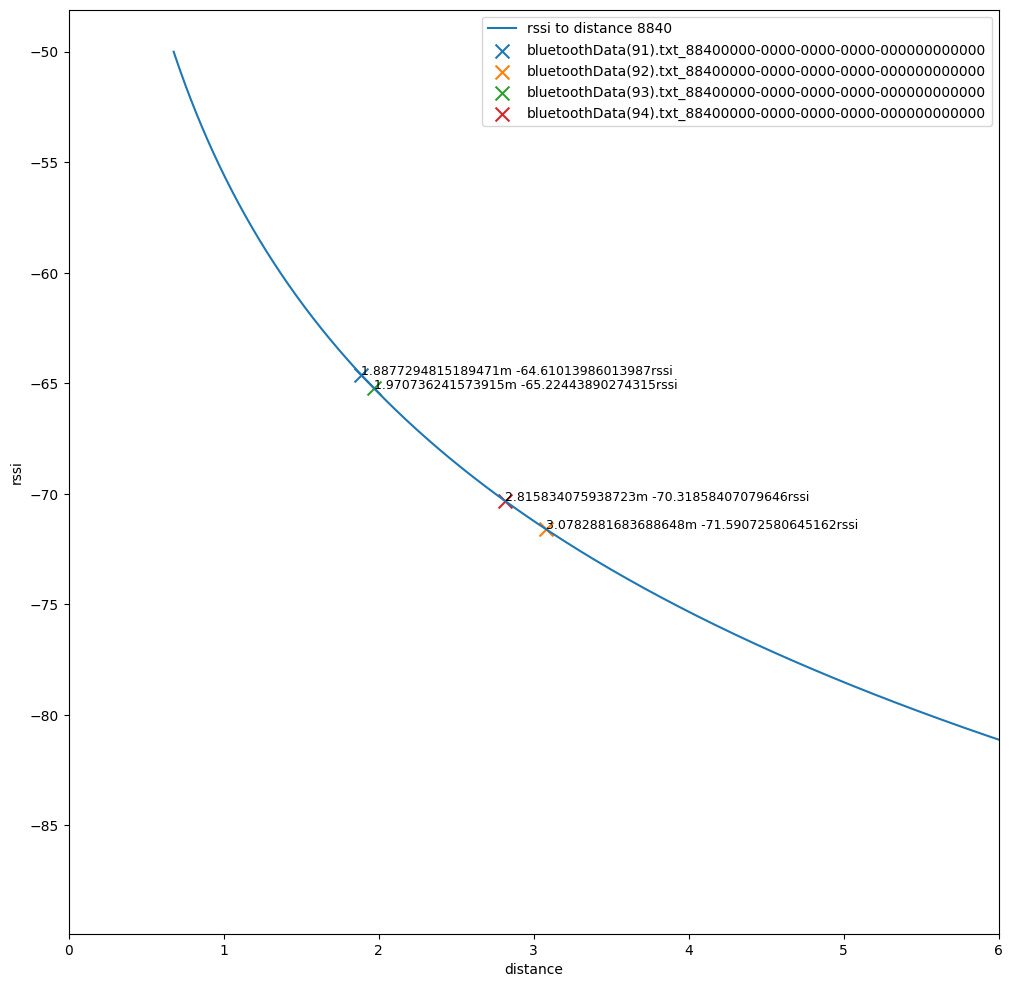

In [6]:
# visualize the beacon RSSI to distance


def rssi_to_distance(rssi):
    txPower = -55.54
    n = 3.287
    return 10 ** ((txPower - rssi) / (10 * n))
# 55 : 3.544m
# 56 : 3.544m
# 57 : 5.748m
real_distance = {"79": 3.544, "80": 3.544, "81": 5.748, "82": 3.162, "83" : 4.498}


plt.figure(figsize=(12, 12))
rssi_values = np.linspace(-88, -50, 1000)
distance = rssi_to_distance(rssi_values)
plt.plot(distance, rssi_values, label='rssi to distance 8840')
# for beacon_group in beacon_data:
#     for beacon in beacon_group:
#         plt.scatter(rssi_to_distance(beacon['rssi']), beacon['rssi'], s=10, marker='o', c='b')
pattern = r"\((.*?)\)"
for filename, mean_rssi in filename_to_median_mean_rssi.items():  
    if re.match(r'bluetoothData.*_8840.*', filename):
        distance = rssi_to_distance(mean_rssi)
        file_number = re.search(pattern, filename).group(0)
        plt.scatter(distance, mean_rssi, s=100, marker='x', label=filename)
        plt.text(distance, mean_rssi, f"{distance}m {mean_rssi}rssi", fontsize=9)
        for real_uuid, real_dis in real_distance.items():
            if filename.find(real_uuid) != -1:
                plt.scatter(real_dis, mean_rssi, s=100, marker='o', c='r')
                plt.text(real_dis, mean_rssi, f"{file_number}, real {real_dis}m", fontsize=9)
                break
plt.xlabel('distance')
plt.xlim(0, 6)
plt.ylabel('rssi')
plt.legend()
plt.show()
